# Revised Topic using Morphological Transformation

## 1. Global Processing Morphological Dilation

- Morphological Closing was used because enhancing traces wont be possible by Morphological Dilation alone since dilation only concerns about **expanding holes/gaps** in the image.
- Shown below is the image being processed using dilation only.

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Specify the folder path
folder_path = "00041"

# Step 2: List and filter files with "test" in their name
all_files = os.listdir(folder_path)
test_files = [file for file in all_files if "test" in file]
test_files = test_files[:10]

# Step 3: Define the kernel for morphological operations
kernel = np.ones((3, 3), np.uint8)

# Step 4: Process each filtered file
for test_file in test_files:
    file_path = os.path.join(folder_path, test_file)
    
    # Read the image in grayscale
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Failed to read image: {test_file}")
        continue
    
    # Resize the image for manageability
    resized_image = cv2.resize(image, (0, 0), fx=0.5, fy=0.5)

    # Apply dilation to enhance the traces
    cleaned_image = cv2.dilate(resized_image, kernel, iterations=2)

    # Step 5: Display the original image and the result after dilation
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(resized_image, cmap='gray')
    plt.title(f"Original Image: {test_file}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cleaned_image, cmap='gray')
    plt.title(f"Cleaned Image: {test_file}")
    plt.axis('off')
    
    plt.show()


- If we use Morphological Closing *(Erosion then Dilation)*, the results are shown below.

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Specify the folder path
folder_path = "00041"

# Step 2: List and filter files with "test" in their name
all_files = os.listdir(folder_path)
test_files = [file for file in all_files if "test" in file]
test_files = test_files[:10]

# Step 3: Define the kernel for morphological operations
kernel = np.ones((3, 3), np.uint8)

# Step 4: Process each filtered file
for test_file in test_files:
    file_path = os.path.join(folder_path, test_file)
    
    # Read the image in grayscale
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Failed to read image: {test_file}")
        continue
    
    # Resize the image for manageability
    resized_image = cv2.resize(image, (0, 0), fx=0.5, fy=0.5)

    # Apply erosion to reduce short circuits
    eroded_image = cv2.erode(resized_image, kernel, iterations=3)

    # Apply dilation to enhance the traces
    cleaned_image = cv2.dilate(eroded_image, kernel, iterations=3)

    # Step 5: Display the results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(resized_image, cmap='gray')
    plt.title(f"Original: {test_file}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(eroded_image, cmap='gray')
    plt.title("After Erosion")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cleaned_image, cmap='gray')
    plt.title("Cleaned Image")
    plt.axis('off')

    plt.show()

- But the results are still not up to what we are expected, so we created a program that we can manually improve PCB Traces using Morphological Dilation and Erosion.
- The code below allows us to manually select a region of interest to that are need of enhancements. We can select what opreation modes (Dilation or Erosion) to use to specific areas we want to enhance.

In [ ]:
import cv2
import numpy as np

def nothing(x):
    """Dummy function for trackbar callbacks."""
    pass

def save_image(image, path):
    """Saves the processed image to a file."""
    cv2.imwrite(path, image)
    print(f"Image saved to {path}")

# Load the image in grayscale
image_path = "00041/00041013_test.jpg"
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if image is loaded successfully
if original_image is None:
    print(f"Error: Image not loaded. Check the file path: {image_path}")
    exit()

# Resize the image for better visualization
resize_width = 600
aspect_ratio = resize_width / original_image.shape[1]
resize_height = int(original_image.shape[0] * aspect_ratio)
processed_image = cv2.resize(original_image, (resize_width, resize_height))

# Create control windows
cv2.namedWindow("Controls")
cv2.namedWindow("Morphological Operations")

# Create trackbars in the "Controls" window
cv2.createTrackbar("Threshold", "Controls", 127, 255, nothing)
cv2.createTrackbar("Kernel Size", "Controls", 3, 20, nothing)
cv2.createTrackbar("Iterations", "Controls", 1, 10, nothing)
cv2.createTrackbar("Operation", "Controls", 0, 1, nothing)  # 0 = Dilation, 1 = Erosion
cv2.createTrackbar("Save", "Controls", 0, 1, nothing)  # 0 = Do not save, 1 = Save

# Allow the user to select and process multiple ROIs
while True:
    # Let the user select ROI from the processed image
    roi = cv2.selectROI("Select ROI", processed_image, showCrosshair=True)
    if roi == (0, 0, 0, 0):  # No ROI selected
        print("No ROI selected. Exiting ROI selection mode.")
        break  # Exit the ROI selection mode

    x, y, w, h = map(int, roi)
    roi_image = processed_image[y:y+h, x:x+w].copy()  # Create a copy of the selected ROI to prevent issues with trackbars

    # Processing loop for this ROI
    while True:
        # Get trackbar positions for settings
        threshold = cv2.getTrackbarPos("Threshold", "Controls")
        kernel_size = cv2.getTrackbarPos("Kernel Size", "Controls")
        iterations = cv2.getTrackbarPos("Iterations", "Controls")
        operation = cv2.getTrackbarPos("Operation", "Controls")  # 0 = Dilation, 1 = Erosion
        save_flag = cv2.getTrackbarPos("Save", "Controls")  # Check if Save is triggered

        # Ensure kernel size is odd and not zero
        kernel_size = max(1, kernel_size)
        if kernel_size % 2 == 0:
            kernel_size += 1

        # Apply binary threshold to the ROI
        _, thresh_image = cv2.threshold(roi_image, threshold, 255, cv2.THRESH_BINARY)

        # Create the kernel
        kernel = np.ones((kernel_size, kernel_size), np.uint8)

        # Apply dilation or erosion
        if operation == 0:
            processed_roi = cv2.dilate(thresh_image, kernel, iterations=iterations)
        else:
            processed_roi = cv2.erode(thresh_image, kernel, iterations=iterations)

        # Display the processed image
        display_image = processed_image.copy()
        display_image[y:y+h, x:x+w] = processed_roi  # Update the display image with the processed ROI

        cv2.imshow("Morphological Operations", display_image)

        # Save the image if the Save button (trackbar) is triggered
        if save_flag == 1:
            processed_image[y:y+h, x:x+w] = processed_roi  # Save the changes to the main image
            save_image(processed_image, f"processed_image.jpg")  # Save with a generic name
            cv2.setTrackbarPos("Save", "Controls", 0)  # Reset the Save button (trackbar) to 0
            break  # Exit the ROI adjustment loop to select another ROI

        key = cv2.waitKey(1) & 0xFF
        if key == 27:  # Exit on ESC
            break

    if key == 27:  # Exit if ESC is pressed
        break

cv2.destroyAllWindows()


- In this code we use **Morphological Closing and Opening** which is the combination of the Morphological Dilation and Erosion.
- **Morphological Opening** is an erosion followed by a dilation using a specified kernel (structuring element).
- **Morphological Closing** is a dilation followed by an erosion using a specified kernel (structuring element).

Image saved to processed_image.jpg
Image saved to processed_image.jpg
Image saved to processed_image.jpg
Image saved to processed_image.jpg
Image saved to processed_image.jpg
Image saved to processed_image.jpg
Image saved to processed_image.jpg
Image saved to processed_image.jpg
Image saved to processed_image.jpg
Image saved to processed_image.jpg
Image saved to processed_image.jpg
Image saved to processed_image.jpg
Image saved to processed_image.jpg
No ROI selected. Exiting ROI selection mode.


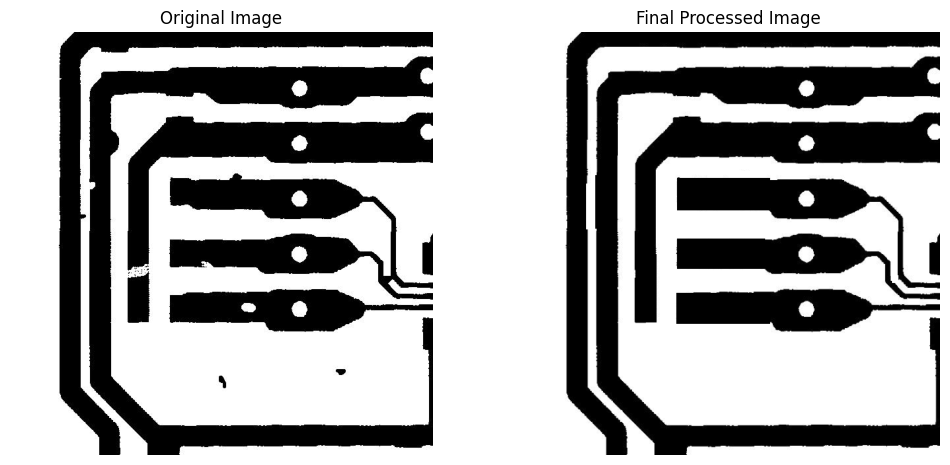

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def nothing(x):
    """Dummy function for trackbar callbacks."""
    pass

def save_image(image, path):
    """Saves the processed image to a file."""
    cv2.imwrite(path, image)
    print(f"Image saved to {path}")

# Load the image in grayscale
image_path = "00041/00041013_test.jpg"
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if image is loaded successfully
if original_image is None:
    print(f"Error: Image not loaded. Check the file path: {image_path}")
    exit()

# Resize the image for better visualization
resize_width = 600
aspect_ratio = resize_width / original_image.shape[1]
resize_height = int(original_image.shape[0] * aspect_ratio)
processed_image = cv2.resize(original_image, (resize_width, resize_height))

# Create control windows
cv2.namedWindow("Controls", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Controls", 400, 300)  # Set fixed width and height for the Controls window
cv2.namedWindow("Morphological Operations")

# Create trackbars in the "Controls" window
cv2.createTrackbar("Threshold", "Controls", 127, 255, nothing)
cv2.createTrackbar("Kernel Size", "Controls", 3, 20, nothing)
cv2.createTrackbar("Iterations", "Controls", 1, 10, nothing)
cv2.createTrackbar("Operation", "Controls", 0, 1, nothing)  # 0 = Opening, 1 = Closing
cv2.createTrackbar("Save", "Controls", 0, 1, nothing)  # 0 = Do not save, 1 = Save

# Allow the user to select and process multiple ROIs
while True:
    # Let the user select ROI from the processed image
    roi = cv2.selectROI("Select ROI", processed_image, showCrosshair=True)
    if roi == (0, 0, 0, 0):  # No ROI selected
        print("No ROI selected. Exiting ROI selection mode.")
        break  # Exit the ROI selection mode

    x, y, w, h = map(int, roi)
    roi_image = processed_image[y:y+h, x:x+w].copy()  # Create a copy of the selected ROI to prevent issues with trackbars

    # Processing loop for this ROI
    while True:
        # Get trackbar positions for settings
        threshold = cv2.getTrackbarPos("Threshold", "Controls")
        kernel_size = cv2.getTrackbarPos("Kernel Size", "Controls")
        iterations = cv2.getTrackbarPos("Iterations", "Controls")
        operation = cv2.getTrackbarPos("Operation", "Controls")  # 0 = Opening, 1 = Closing
        save_flag = cv2.getTrackbarPos("Save", "Controls")  # Check if Save is triggered

        # Ensure kernel size is odd and not zero
        kernel_size = max(1, kernel_size)
        if kernel_size % 2 == 0:
            kernel_size += 1

        # Apply binary threshold to the ROI
        _, thresh_image = cv2.threshold(roi_image, threshold, 255, cv2.THRESH_BINARY)

        # Create the kernel
        kernel = np.ones((kernel_size, kernel_size), np.uint8)

        # Apply opening or closing
        if operation == 0:
            processed_roi = cv2.morphologyEx(thresh_image, cv2.MORPH_OPEN, kernel, iterations=iterations)
        else:
            processed_roi = cv2.morphologyEx(thresh_image, cv2.MORPH_CLOSE, kernel, iterations=iterations)

        # Display the processed image using OpenCV
        display_image = processed_image.copy()
        display_image[y:y+h, x:x+w] = processed_roi  # Update the display image with the processed ROI

        cv2.imshow("Morphological Operations", display_image)

        # Save the image if the Save button (trackbar) is triggered
        if save_flag == 1:
            processed_image[y:y+h, x:x+w] = processed_roi  # Save the changes to the main image
            save_image(processed_image, f"processed_image.jpg")  # Save with a generic name
            cv2.setTrackbarPos("Save", "Controls", 0)  # Reset the Save button (trackbar) to 0
            break  # Exit the ROI adjustment loop to select another ROI

        key = cv2.waitKey(1) & 0xFF
        if key == 27:  # Exit on ESC
            break

    if key == 27:  # Exit if ESC is pressed
        break

# Display the original and final processed image using matplotlib
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(processed_image, cmap='gray')
plt.title("Final Processed Image")
plt.axis('off')

plt.show()

cv2.destroyAllWindows()
